In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import plotting
from pathlib import Path
import auxiliary
#from MCMC_affine_multi import run_MCMC as run
from MCMC_aux import get_model
import os
import scipy.interpolate as interp
import mass_calc as mc
import matplotlib
import Parameters as par
import Models as mod
import Kernels as ker
import GP_Likelihood as gp
%matplotlib inline

2813.2308006313287 16620.585819951895


(0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0,

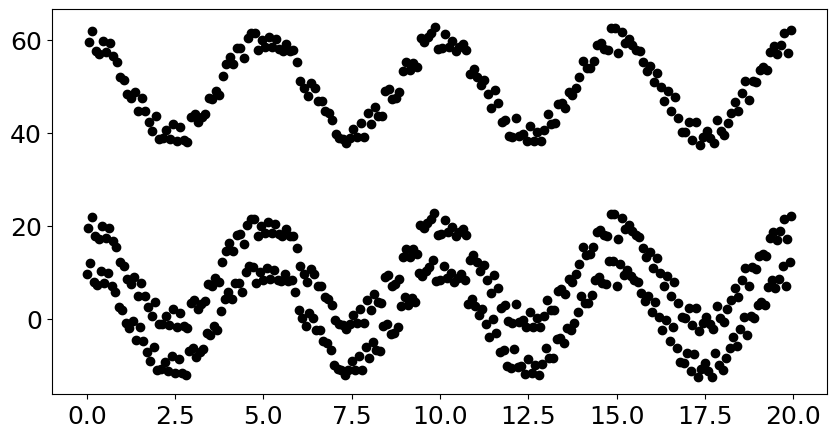

In [5]:
def ecc_anomaly(M, ecc, max_itr=200):
    '''
    ----------
    M : float
        Mean anomaly
    ecc : float
        Eccentricity, number between 0. and 0.99
    max_itr : integer, optional
        Number of maximum iteration in E computation. The default is 200.
    Returns
    -------
    E : float
        Eccentric anomaly
    '''
    
    E0 = M
    E = M
    #print("E before = ", E)
    for i in range(max_itr):
        f = E0 - ecc*np.sin(E0) - M
        fp = 1. - ecc*np.cos(E0)
        E = E0 - f/fp
        
        # check for convergence
        if (np.linalg.norm(E - E0, ord=1) <= 1.0e-10):
            return E
            break
        # if not convergence continue
        E0 = E
    
    # no convergence, return best estimate
    #print('Best estimate E = ',E[0:5])
    return E

time1 = np.arange(0., 20., 0.1)
A = 10.
P = 5
Aerr = []
Perr = []
Rerr = []
Keperr = []
for i in time1:
    Aerr.append(A+np.random.uniform(0,0))
    Perr.append(2*np.pi/(P+np.random.uniform(0,0)))
    Rerr.append(np.random.uniform(-3,3))
    Keperr.append(np.random.uniform(-3,3))
y1 = Aerr*np.cos(time1*(Perr))+Rerr
y1_err = np.ones_like(y1)*0.5
#time1_flag = np.ones_like(time1)

time2 = np.arange(0.05,20.05,0.1)
y2 = Aerr*np.cos(time2*(Perr))+Rerr+50
y2_err = np.ones_like(y2)*0.5
#time2_flag = np.zeros_like(time2)

time3 = np.arange(0.04,20.04,0.1)
y3 = Aerr*np.cos(time3*(Perr))+Rerr+10
y3_err = np.ones_like(y3)*0.5
#time3_flag = np.ones_like(time3)*2

#time = np.concatenate((time1, time2, time3))
#y = np.concatenate((y1, y2, y3))
#y_err = np.concatenate((y1_err, y2_err, y3_err))
#flags = np.concatenate((time1_flag, time2_flag, time3_flag))
#time, y, y_err, flags = zip(*sorted(zip(time, y, y_err, flags)))
#time = np.array(time)

time, y, y_err, flags = mod.get_data((time1,time2,time3), (y1,y2,y3), (y1_err,y1_err,y1_err))
print(flags)


fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(1,1,1)
ax.scatter(time,y, c="k")
plt.show()
#ax.plot(time, y ,c="r")

K = 20
ecc = 0.5
omega = np.pi/2.
Pl = 3.6
t0 = time[0]

M = 2*np.pi * (time-t0) / Pl
E = ecc_anomaly(M, ecc)
nu = 2. * np.arctan(np.sqrt((1.+ecc)/(1.-ecc)) * np.tan(E/2.))

Kep = K * (np.cos(omega + nu) + ecc*np.cos(omega))
y += Kep

K = 15
ecc = 0.7
omega = np.pi/4
Pl = 1.2
t0 = time[0]

M = 2*np.pi * (time-t0) / Pl
E = ecc_anomaly(M, ecc)
nu = 2. * np.arctan(np.sqrt((1.+ecc)/(1.-ecc)) * np.tan(E/2.))

#Kep2 = K * (np.cos(omega + nu) + ecc*np.cos(omega)) + Keperr

#fig = plt.figure(figsize = (10,5))
#ax = fig.add_subplot(1,1,1)
#ax.scatter(time,Kep, c="k")
#plt.show()

#fig = plt.figure(figsize = (10,5))
#ax = fig.add_subplot(1,1,1)
#ax.scatter(time,Kep2, c="k")
#plt.show()

#y = y+Kep+Kep2
#fig = plt.figure(figsize = (10,5))
#ax = fig.add_subplot(1,1,1)
#ax.scatter(time,y, c="k")
#plt.show()

{'gp_amp': 'gp_amp', 'gp_timescale': 'gp_timescale'}
{'offset_0': Parameter object: value = 50.0, error=0.5 (vary = True) 
, 'offset_1': Parameter object: value = 10.0, error=0.5 (vary = True) 
, 'P_0': Parameter object: value = 20, error=0.5 (vary = True) 
, 'K_0': Parameter object: value = 3.6, error=1.0 (vary = True) 
, 'ecc_0': Parameter object: value = 0.5, error=0.1 (vary = True) 
, 'omega_0': Parameter object: value = 1.13, error=0.05 (vary = True) 
, 't0_0': Parameter object: value = 0.0, error=10.0 (vary = True) 
}
{'offset_0': Parameter object: value = 50.0, error=0.5 (vary = True) 
}
offset_0
{'offset_1': Parameter object: value = 10.0, error=0.5 (vary = True) 
}
offset_1
[ 2.30396296e+00  1.21608506e+01  5.21246711e+01  1.94173012e+00
  1.17933721e+01  5.17560667e+01  1.56862123e+00  1.14180117e+01
  5.13803303e+01  1.19210930e+00  1.10421749e+01  5.10048369e+01
  8.19341389e-01  1.06727418e+01  5.06363893e+01  4.56676895e-01
  1.03156587e+01  5.02808240e+01  1.09370584e-01

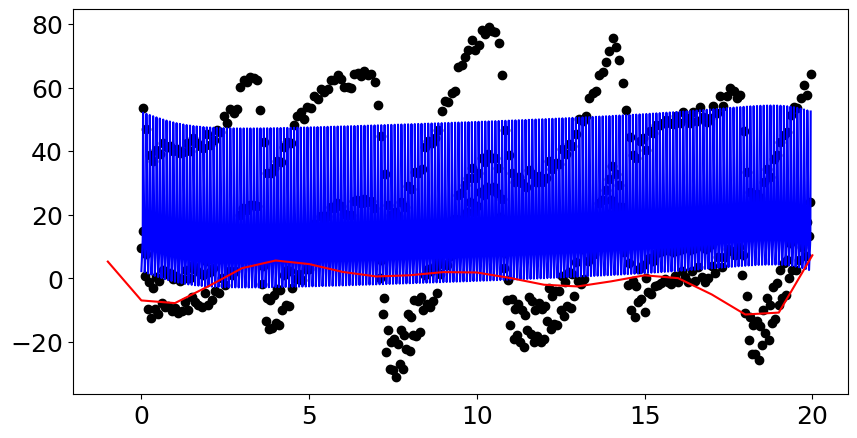

In [11]:
iterations = 10000
numb_chains = 100
hparam = par.par_create("Expsquared")
print(hparam)
hparam["gp_amp"] = par.parameter(value = 10., error = 0.5, vary = True)
hparam["gp_timescale"] = par.parameter(value = 5., error = 0.5, vary = True)
prior_list = []
pri_amp = par.pri_create("gp_amp", "Uniform", [5.,15.])
prior_list.append(pri_amp)
pri_per = par.pri_create("gp_timescale", "Uniform", [0.,10.])
prior_list.append(pri_per)

model_list = ["Offset", "Offset", "Keplerian"]
model_par = mod.mod_create(model_list)

model_par["P_0"]=par.parameter(value=20, error=0.5, vary=True)
model_par["K_0"]=par.parameter(value=3.6, error=1., vary=True)
model_par["ecc_0"]=par.parameter(value=0.5, error=0.1, vary=True)
model_par["omega_0"]=par.parameter(value=1.13, error=0.05, vary=True)
model_par["t0_0"]=par.parameter(value=0., error=10., vary=True)
model_par["offset_0"] = par.parameter(50., 0.5, True) # applied to np.zeros + 1 (2nd item in get_data times list)
model_par["offset_1"] = par.parameter(10., 0.5, True) # applied ot np.zeros + 2 (3rd item in get_data times list)
print(model_par)
model_y = get_model(model_list, time, model_par, to_ecc=False, flags = flags)
print(model_y)

loglik = gp.GPLikelyhood(time, y, y_err, hparam, "Expsquared", model_y, model_par)
logL = loglik.LogL(prior_list)
xpred = np.arange(time1[0]-1., time1[-1]+1., 1)
GP_y, GP_err = loglik.predict(xpred)

plt.figure(figsize=(10,5))
plt.scatter(time,y, c="k")
plt.plot(time,model_y, c="b")
plt.plot(xpred,GP_y,c="r")

{'offset_0': 'offset', 'offset_1': 'offset'}


AttributeError: 'dict' object has no attribute 'remove'